|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | -2.427    | 37.52     | 0.9508    | 0.732     |
| 2         | -2.554    | 59.91     | 0.1569    | 0.1561    |
| 3         | -2.455    | 5.903     | 0.8663    | 0.6012    |
| 4         | -2.618    | 70.84     | 0.02156   | 0.9699    |
| 5         | -2.559    | 83.26     | 0.2131    | 0.1819    |
| 6         | -2.571    | 18.42     | 0.3049    | 0.5248    |
| 7         | -2.574    | 43.25     | 0.2919    | 0.6119    |
| 8         | -2.569    | 14.04     | 0.2929    | 0.3664    |
| 9         | -2.468    | 45.66     | 0.7854    | 0.1998    |
| 10        | -2.449    | 51.47     | 0.5928    | 0.04655   |
| 11        | -2.447    | 51.39     | 0.6451    | 0.05812   |
| 12        | -2.535    | 48.53     | 0.4862    | 0.279     |
| 13        | -2.491    | 36.15     | 0.7275    | 0.9038    |
| 14        | -2.272    | 38.31     | 0.03416   | 0.01485   |
| 15    

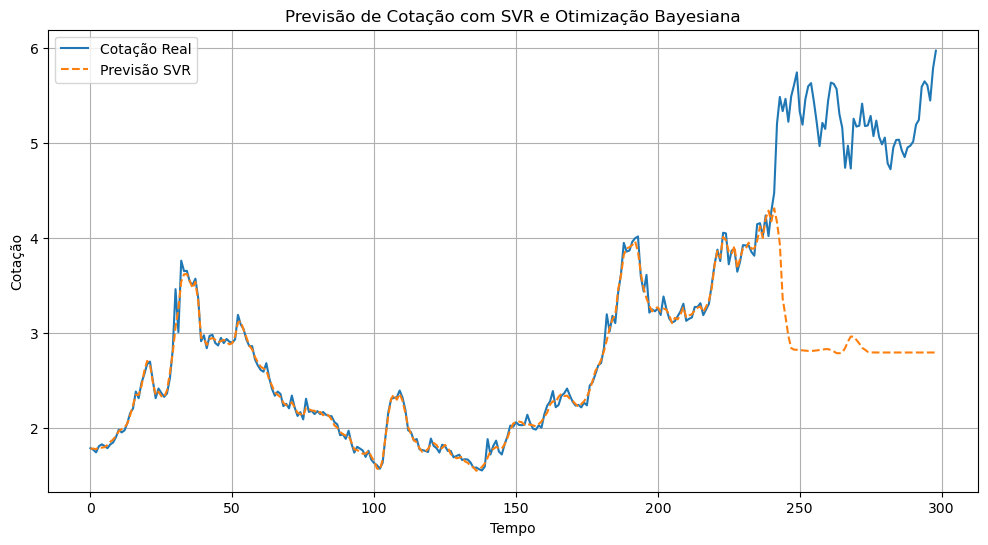

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Carregar os dados
df = pd.read_csv("./Dataset_Dolar.csv")

# Criar a coluna data_formatada a partir de ano e mês
#df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")
#df = df.sort_values(by="t", ascending=True)

# Definir variáveis independentes (X) e dependente (y)
X = df[['ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Aplicar transformação polinomial de grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Função de avaliação para otimização bayesiana
def svr_evaluate(C, epsilon, gamma):
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel="rbf")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return -mean_absolute_error(y_test, y_pred)  # Negativo para maximizar

# Espaço de busca para os hiperparâmetros
param_bounds = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (0.0001, 1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(f=svr_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max["params"]

# Treinar modelo final com os melhores parâmetros
best_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"], kernel="rbf")
best_svr.fit(X_train_scaled, y_train)

# Previsões
df["cotacao_pred"] = best_svr.predict(scaler.transform(poly.transform(X)))

# Avaliação
mae = mean_absolute_error(y_test, best_svr.predict(X_test_scaled))
mse = mean_squared_error(y_test, best_svr.predict(X_test_scaled))
print(f"Melhores parâmetros: {best_params}")
print(f"MAE: {mae}, MSE: {mse}")

# Plotar previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(df["cotacao"], label="Cotação Real")
plt.plot(df["cotacao_pred"], label="Previsão SVR", linestyle='--')
plt.xlabel("Tempo")
plt.ylabel("Cotação")
plt.title("Previsão de Cotação com SVR e Otimização Bayesiana")
plt.legend()
plt.grid()
plt.show()


In [33]:
df.

TypeError: 'RangeIndex' object is not callable

Melhores Parâmetros: {'C': 62.28017684615158, 'epsilon': 0.028001956789306757, 'gamma': 0.8545583121815898}
Mean Absolute Error (MAE): 0.09548824612509654
Mean Squared Error (MSE): 0.01734247355752143
R² Score: 0.987469501851425


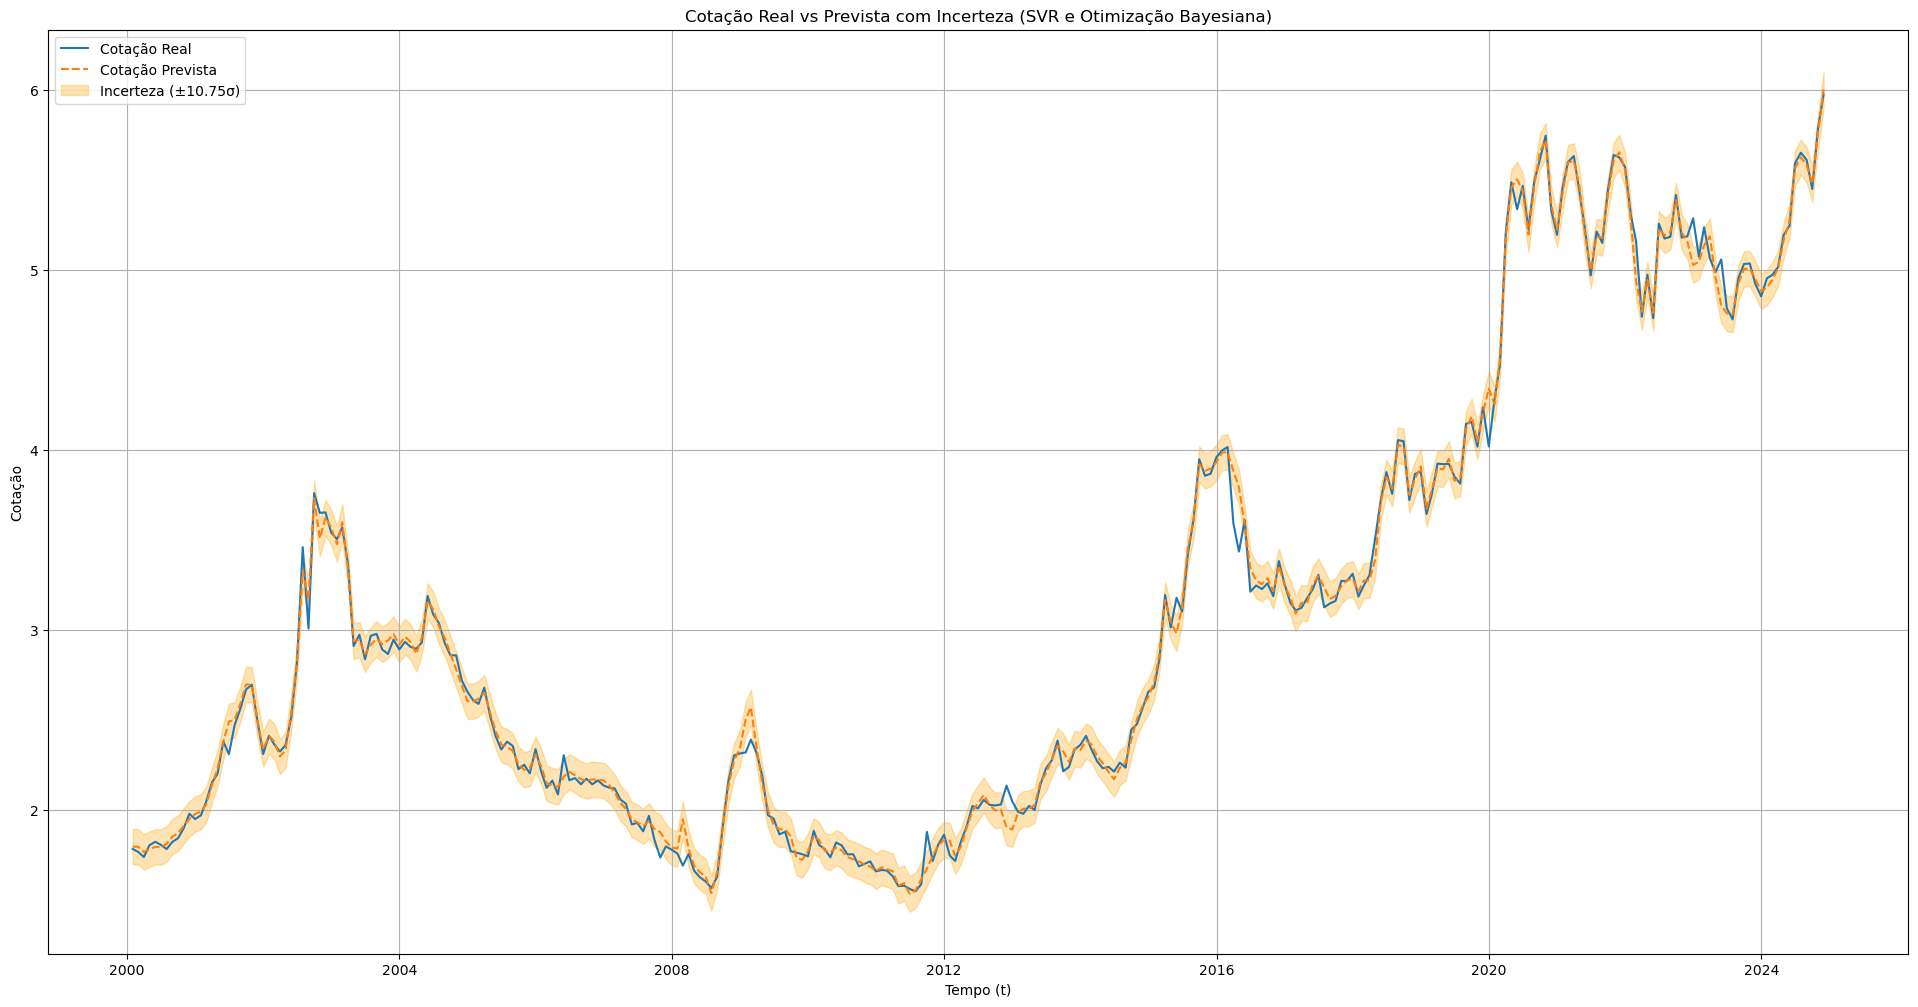

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
#df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)
df = df.sort_values(by="t", ascending=True)


# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Transformação polinomial de grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Padronizar os dados
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_poly)
X_scaled = scaler.fit_transform(X)
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Função de avaliação para otimização bayesiana
def svr_evaluate(C, epsilon, gamma):
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel="rbf")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_absolute_error(y_test, y_pred)  # Negativo para maximizar

# Espaço de busca para os hiperparâmetros
param_bounds = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (0.0001, 1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(f=svr_evaluate, pbounds=param_bounds, verbose=0, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max["params"]

# Treinar modelo final com os melhores parâmetros
best_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"], kernel="rbf")
best_svr.fit(X_train, y_train)

# Previsões
y_pred = best_svr.predict(X_test)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Melhores Parâmetros: {best_params}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Calcular desvio padrão da previsão
y_std = np.std(y_pred - y_test)

# Adicionar previsões ao DataFrame original
df['cotacao_pred'] = best_svr.predict(X_scaled)

# Visualização gráfica com bandas de incerteza
variation = 0.75
plt.figure(figsize=(24, 12))
plt.plot(df['data_formatada'], df['cotacao'], label='Cotação Real')
plt.plot(df['data_formatada'], df['cotacao_pred'], label='Cotação Prevista', linestyle='--')
plt.fill_between(df['data_formatada'],
                 df['cotacao_pred'] - variation * y_std,
                 df['cotacao_pred'] + variation * y_std,
                 color='orange', alpha=0.3, label=f'Incerteza (±1{variation}σ)')
plt.xlabel('Tempo (t)')
plt.ylabel('Cotação')
plt.title('Cotação Real vs Prevista com Incerteza (SVR e Otimização Bayesiana)')
plt.legend()
plt.grid()
plt.show()


In [23]:
train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)[0]

,t,ipca_acumulado_1,selic_1,divida_pp_1,fed_rate_1,ipca_acumulado_2,selic_2,divida_pp_2,fed_rate_2,ipca_acumulado_3,...,divida_pp_3,fed_rate_3,ipca_acumulado_4,selic_4,divida_pp_4,fed_rate_4,ipca_acumulado_5,selic_5,divida_pp_5,fed_rate_5
298,1,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,...,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45
297,2,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,...,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45
296,3,9.35,18.869524,51.27,5.73,9.22,18.937619,51.27,5.45,9.22,...,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45
295,4,9.57,18.846667,51.27,5.85,9.35,18.869524,51.27,5.73,9.22,...,51.27,5.45,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45
294,5,9.99,18.618421,51.27,6.02,9.57,18.846667,51.27,5.85,9.35,...,51.27,5.73,9.22,18.937619,51.27,5.45,9.22,18.937619,51.27,5.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,235,127.93,6.400000,76.67,2.38,127.92,6.400000,76.55,2.39,127.79,...,77.12,2.42,127.22,6.400000,76.71,2.41,126.47,6.400000,75.52,2.40
63,236,128.12,6.400000,76.83,2.40,127.93,6.400000,76.67,2.38,127.92,...,76.55,2.39,127.79,6.400000,77.12,2.42,127.22,6.400000,76.71,2.41
62,237,128.23,5.900000,77.56,2.13,128.12,6.400000,76.83,2.40,127.93,...,76.67,2.38,127.92,6.400000,76.55,2.39,127.79,6.400000,77.12,2.42
61,238,128.19,5.709524,76.60,2.04,128.23,5.900000,77.56,2.13,128.12,...,76.83,2.40,127.93,6.400000,76.67,2.38,127.92,6.400000,76.55,2.39


|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | -5.994    | 374.6     | 0.9512    | 0.732     |
| 2         | -5.139    | 598.7     | 0.1645    | 0.1561    |
| 3         | -6.053    | 58.18     | 0.8675    | 0.6012    |
| 4         | -6.578    | 708.1     | 0.03038   | 0.9699    |
| 5         | -5.597    | 832.5     | 0.2202    | 0.1819    |
| 6         | -6.245    | 598.9     | 0.766     | 0.9568    |
| 7         | -3.902    | 599.1     | 0.4311    | 0.06727   |
| 8         | -3.996    | 598.6     | 0.1565    | 0.09838   |
| 9         | -3.487    | 599.3     | 0.1534    | 0.0398    |
| 10        | -6.127    | 599.0     | 0.4667    | 0.3023    |
| 11        | -5.033    | 599.4     | 0.3954    | 0.1215    |
| 12        | -4.018    | 599.5     | 0.4328    | 0.07193   |
| 13        | -5.69     | 599.3     | 0.1406    | 0.2368    |
| 14        | -3.065    | 599.3     | 0.02984   | 0.04617   |
| 15    

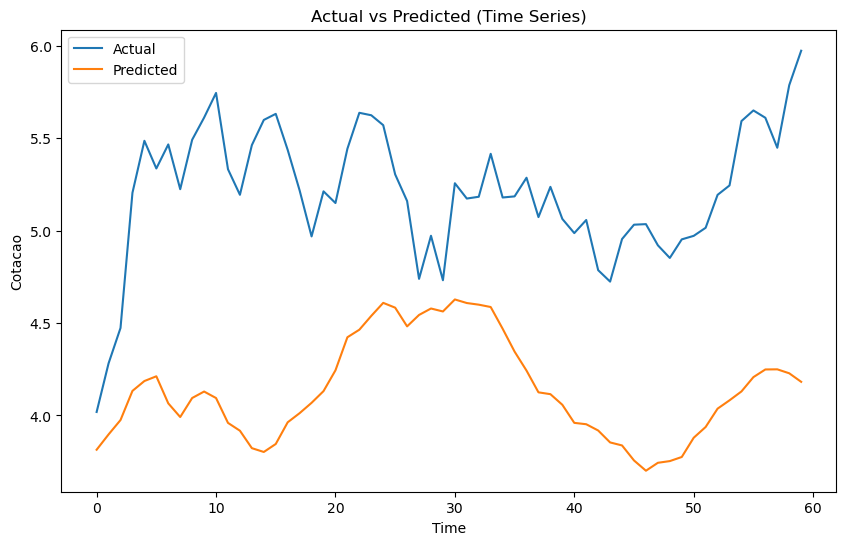

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the data
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Create the formatted date column
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)
df = df.sort_values(by="t", ascending=True)

# Define independent (X) and dependent (y) variables
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Split the data into training and testing sets (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the SVR hyperparameter space for Bayesian Optimization
def svr_cv(C, epsilon, gamma):
    """
    Objective function for Bayesian Optimization.
    """
    # Create the SVR model with the given hyperparameters
    model = SVR(C=C, epsilon=epsilon, gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Return the negative mean squared error (to maximize)
    return -mean_squared_error(y_test, y_pred)

# Define the parameter bounds for Bayesian Optimization
pbounds = {
    'C': (0.1, 1000),
    'epsilon': (0.01, 1),
    'gamma': (0.0001, 1)
}

# Initialize the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=svr_cv,
    pbounds=pbounds,
    random_state=42,
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

# Train the final SVR model with the best hyperparameters
best_svr = SVR(
    C=best_params['C'],
    epsilon=best_params['epsilon'],
    gamma=best_params['gamma']
)

best_svr.fit(X_train_scaled, y_train)

# Evaluate the final model
y_pred = best_svr.predict(X_test_scaled)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted (Time Series)")
plt.xlabel("Time")
plt.ylabel("Cotacao")
plt.show()

In [26]:
df.columns

Index(['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate', 'cotacao_1', 'ipca_acumulado_1', 'cpi_1',
       'selic_1', 'divida_pp_1', 'fed_rate_1', 'cotacao_2', 'ipca_acumulado_2',
       'cpi_2', 'selic_2', 'divida_pp_2', 'fed_rate_2', 'cotacao_3',
       'ipca_acumulado_3', 'cpi_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
       'cotacao_4', 'ipca_acumulado_4', 'cpi_4', 'selic_4', 'divida_pp_4',
       'fed_rate_4', 'cotacao_5', 'ipca_acumulado_5', 'cpi_5', 'selic_5',
       'divida_pp_5', 'fed_rate_5', 'data_formatada'],
      dtype='object')